In [1]:
import numpy as np
import matplotlib.pyplot as plt

from popai import parse_input
from popai import process_empirical
from popai import process_user_models
from popai import simulate_data
from popai import build_predictors

2024-05-24 15:53:06.054835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Tutorial 3: User Models, Jupyter Notebooks Version

This jupyter notebook walks through each step in running popai, including parsing and reading input data, building SFS, building models, simulating data, training machine learning models, and applying models to empirical data.

## Step 1: Parse the configuration file

We will use the ModelConfigParser class to parse the information from the configuration. A full description of the configuration file, along with an example, is available [here](https://popai.readthedocs.io/en/latest/usage/parsinginput.html). This file provides popai with the information it needs to conduct a species delimitation analysis. 

In [2]:
config_parser = parse_input.ModelConfigParser("../input_files/config_user.txt")
config_values = config_parser.parse_config()

## Step 2: Process empirical data

Next, we will process our empirical data. The format for the empirical data is described in detail [here](https://delimitpy.readthedocs.io/en/latest/usage/parsinginput.html). 

There are three major steps:
1) Read data from fasta files and convert to a numpy array.
2) Choose values for down-projecting the Site Frequency Spectrum.
3) Build SFS with down-projection.

When we perform step 1, we will also see how many SNPs are used to construct our numpy array, and we will use this number later, when simulating data.


### Step 2a: Read data into numpy array

In [3]:
data_processor = process_empirical.DataProcessor(config=config_values)
empirical_array = data_processor.fasta_to_numpy()
# IF YOU USE A FASTA INSTEAD:
#empirical_array = data_processor.vcf_to_numpy()
print(f"Our input data has {empirical_array.shape[0]} individuals and {empirical_array.shape[1]} SNPs.")
average_snps = empirical_array.shape[1]

INFO:popai.process_empirical:Empirical data has 1561 SNPs. If this is very different than the number of SNPs in your simulated data, you may want to change some priors.


Our input data has 60 individuals and 1561 SNPs.


### Step 2b: Choose values for down-projection

SFS cannot be generated from datasets that include missing data. To circumvent this, we use a downsampling approach such as that described in Satler and Carstens [(2017)](https://doi.org/10.1111/mec.14137). We must choose thresholds for each populations (i.e., the minumum number of individuals that must be sampled for a SNP to be used.) To help with this, we use the function find_downsampling from the class DataProcessor. This function generates a dictionary that holds the number of SNPs that meet each threshold.

We will use a folded SFS, meaning that we will build the SFS based on minor allele frequencies.

Since our data should be phased, and we will simulate diploid individuals, we will only consider multiples of 2.

In [4]:
# generate dictionary with the number of SNPs at different sampling thresholds
empirical_2d_sfs_sampling = data_processor.find_downsampling(empirical_array)
print(empirical_2d_sfs_sampling)


{(20, 20, 20): 1561, (20, 20, 18): 1561, (20, 20, 16): 1561, (20, 20, 14): 1561, (20, 20, 12): 1561, (20, 20, 10): 1561, (20, 20, 8): 1561, (20, 20, 6): 1561, (20, 20, 4): 1561, (20, 20, 2): 1561, (20, 18, 20): 1561, (20, 18, 18): 1561, (20, 18, 16): 1561, (20, 18, 14): 1561, (20, 18, 12): 1561, (20, 18, 10): 1561, (20, 18, 8): 1561, (20, 18, 6): 1561, (20, 18, 4): 1561, (20, 18, 2): 1561, (20, 16, 20): 1561, (20, 16, 18): 1561, (20, 16, 16): 1561, (20, 16, 14): 1561, (20, 16, 12): 1561, (20, 16, 10): 1561, (20, 16, 8): 1561, (20, 16, 6): 1561, (20, 16, 4): 1561, (20, 16, 2): 1561, (20, 14, 20): 1561, (20, 14, 18): 1561, (20, 14, 16): 1561, (20, 14, 14): 1561, (20, 14, 12): 1561, (20, 14, 10): 1561, (20, 14, 8): 1561, (20, 14, 6): 1561, (20, 14, 4): 1561, (20, 14, 2): 1561, (20, 12, 20): 1561, (20, 12, 18): 1561, (20, 12, 16): 1561, (20, 12, 14): 1561, (20, 12, 12): 1561, (20, 12, 10): 1561, (20, 12, 8): 1561, (20, 12, 6): 1561, (20, 12, 4): 1561, (20, 12, 2): 1561, (20, 10, 20): 1561,

### Step 2c: Build SFS with down-projection

We want to maximize the number of individuals and SNPs we can use. In this tutorial, since the input data were simulated without missing data, we can use all individuals and still retain all the SNPs.

Now, we are ready to build our SFS. We are only using a single replicate for this test. This makes sense because our ‘empirical’ data are actually simulated data, and we are not downsampling. Because of this, we do not expect much noise. For messier empirical data, use ~10 reps and ensure that results do not differ across replicates.

We will build a set of joint SFS (jSFS) between each pairwise combination of populations. Additionally, we will build a multidimensional SFS (mSFS). When building the mSFS, we can optionally choose to use a binning approach [(Smith et al., 2018)](https://doi.org/10.1111/mec.14223). This creates a coarser SFS, which can be helpful if we have a lot of individuals and not that many SNPs.


In [5]:
downsampling_dictionary = {"A":20, "B":20, "C":20}

# build 10 replicates of the 2d SFS
empirical_2d_sfs = data_processor.numpy_to_2d_sfs(empirical_array, downsampling=downsampling_dictionary, replicates = 1)

# build 10 replicates of the mSFS
empirical_msfs, sfs_average_snps = data_processor.numpy_to_msfs(empirical_array, downsampling=downsampling_dictionary, replicates = 1)

We used an average of 1557 to construct the mSFS.


## Step 3: Build the models, and draw parameters from priors

Next, we will use functions from the ModelReader class to parse your models!

In [6]:
# build the models
model_reader = process_user_models.ModelReader(config_values)
parameterized_models, labels = model_reader.read_models()

## Step 4: Validate the models by  plotting

Now, we must ask "Are these the models I'm looking for?"

One way to easily check this is by plotting the models. The validate_models function takes as input your lists returned from the parameterization command above (draw_parameters). For each model, it will draw one parameterization at random, and plot it using functionality from the drawdemes package.

Make sure the models look like you hoped they would! Remember, you are only seeing a single parameterization for each model.

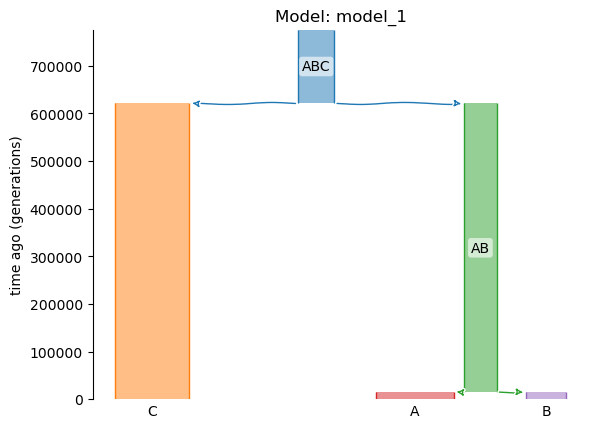

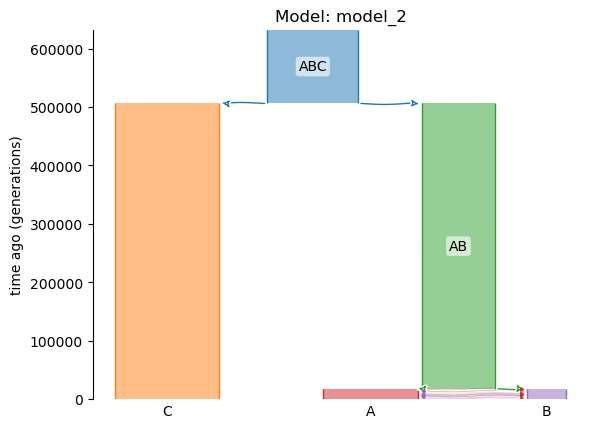

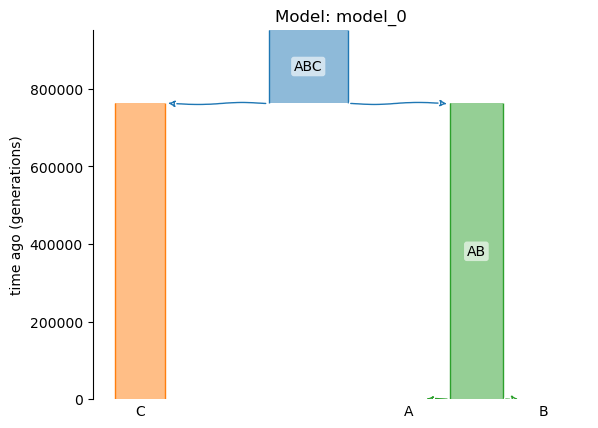

In [7]:
model_reader.validate_models(parameterized_models, labels)

## Step 5: Simulate Data

Now that we have processed our empirical data and build our models, we are ready to simulate the data that we will use to train our machine learning algorithms. We will use information from processing our empirical data (the number of individuals and SNPs to use when bulding the SFS).

In [8]:
data_simulator = simulate_data.DataSimulator(parameterized_models, labels, config=config_values, cores=1, downsampling=downsampling_dictionary, max_sites = average_snps, user=True)

arrays = data_simulator.simulate_ancestry() # simulate ancestry in msprime

Beginning simulation 0 of 3000.
Beginning simulation 100 of 3000.
Beginning simulation 200 of 3000.
Beginning simulation 300 of 3000.
Beginning simulation 400 of 3000.
Beginning simulation 500 of 3000.
Beginning simulation 600 of 3000.
Beginning simulation 700 of 3000.
Beginning simulation 800 of 3000.
Beginning simulation 900 of 3000.
Beginning simulation 1000 of 3000.
Beginning simulation 1100 of 3000.
Beginning simulation 1200 of 3000.
Beginning simulation 1300 of 3000.
Beginning simulation 1400 of 3000.
Beginning simulation 1500 of 3000.
Beginning simulation 1600 of 3000.
Beginning simulation 1700 of 3000.
Beginning simulation 1800 of 3000.
Beginning simulation 1900 of 3000.
Beginning simulation 2000 of 3000.
Beginning simulation 2100 of 3000.
Beginning simulation 2200 of 3000.
Beginning simulation 2300 of 3000.
Beginning simulation 2400 of 3000.
Beginning simulation 2500 of 3000.
Beginning simulation 2600 of 3000.
Beginning simulation 2700 of 3000.
Beginning simulation 2800 of 300

INFO:popai.simulate_data:Simulation execution time: 703.3014988899231 seconds.
INFO:popai.simulate_data:Median simulated data has 8388 SNPs. If this is very different than the number of SNPs in your empirical data, you may want to change some priors.


## Step 6: Build SFS from simulated data

Now, we will create a numpy array and build jSFS and mSFS from our simulated data.

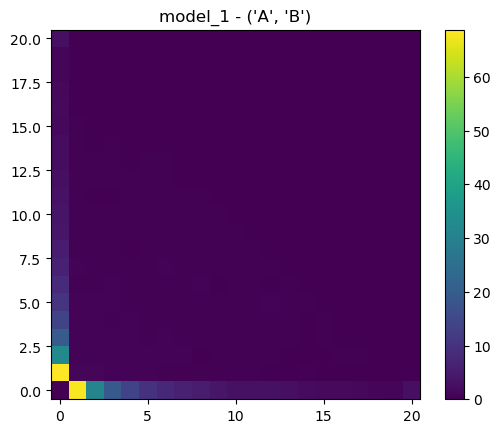

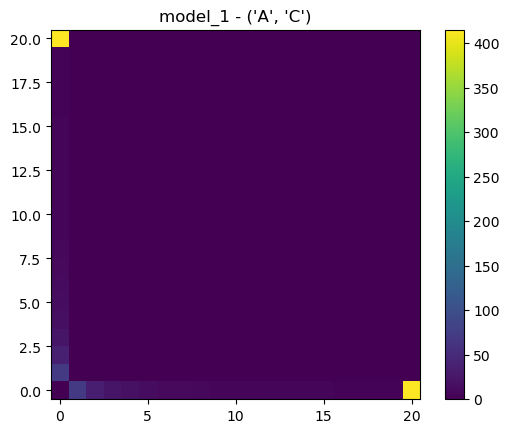

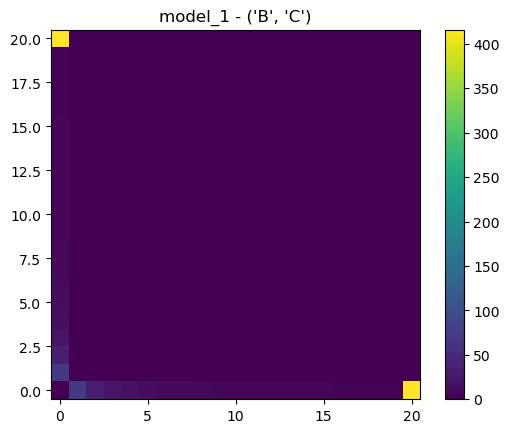

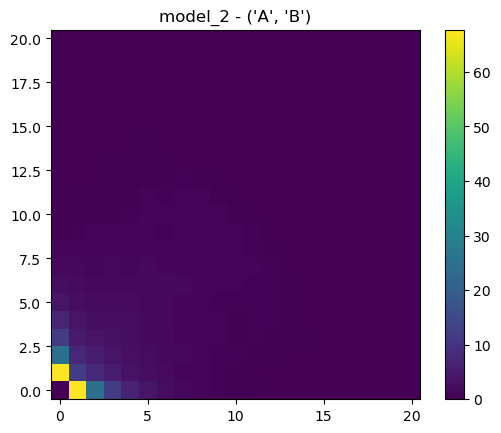

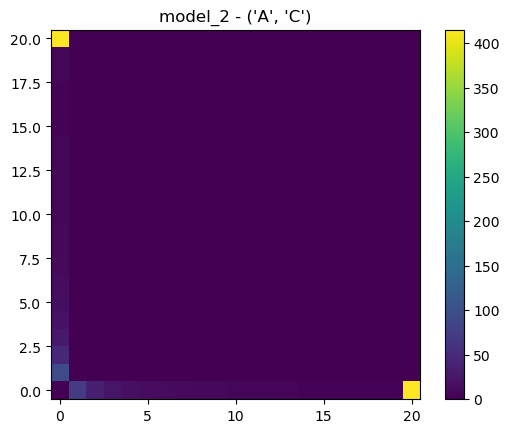

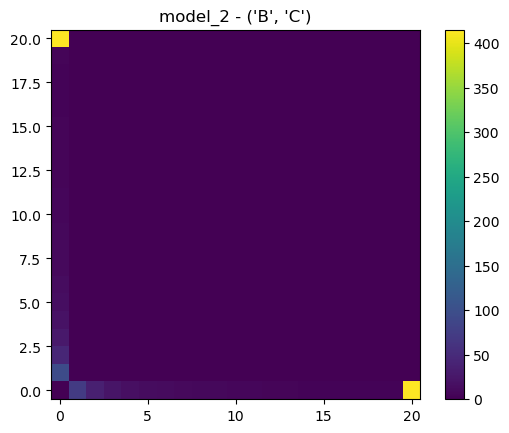

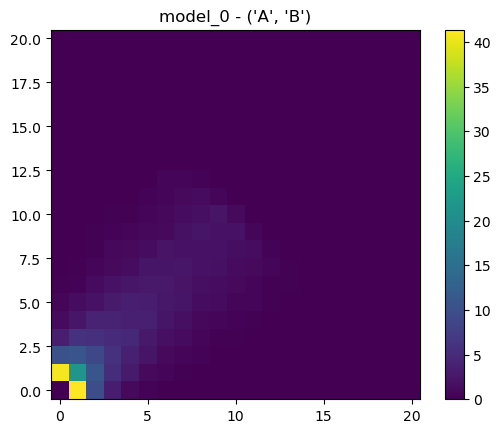

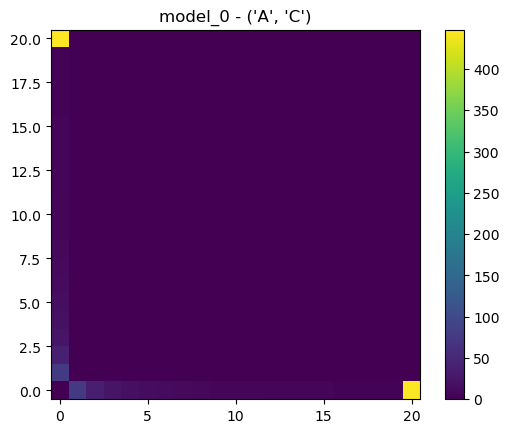

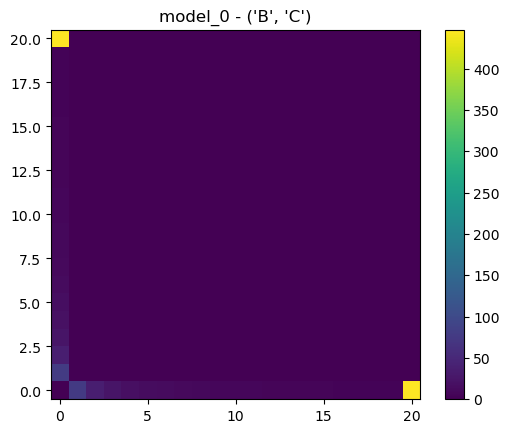

In [9]:
mSFS = data_simulator.mutations_to_sfs(arrays) # generate mSFS
jSFS = data_simulator.mutations_to_2d_sfs(arrays) # generate 2D SFS
data_simulator.plot_2dsfs(jSFS)

## Step 7: Train Classifiers

We now have our simulated training data and are ready to train our classifiers. We will train three classifiers.

1) A Random Forest classifier that takes as input the bins of the multidimensional SFS (mSFS).

2) A Fully Connected Neural Network that takes as input the bins of the multidimensional SFS (mSFS).

3) A Convolutional Neural Network that takes as input the jSFS between all pairs of populations.

4) A Convolutional Neural Network that takes as input alignments formatted as numpy matrices.

### Step 7a: Train the RF classifier

The code will return the model and the confusion matrix and will print the out-of-bag error rates and the confusion matrix on the validation data.

Out-of-Bag (OOB) Error: 0.0279166666666667
Cross-validation scores: [0.95333333 0.95      ]


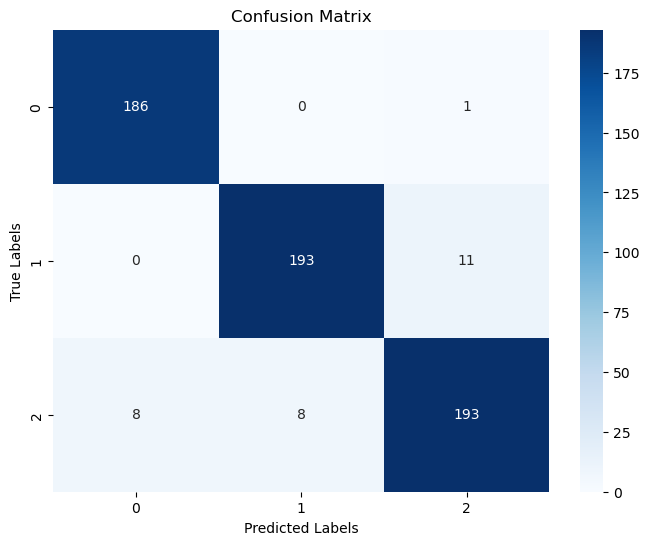

In [10]:
random_forest_sfs_predictor = build_predictors.RandomForestsSFS(config_values, mSFS, labels, user=True)
random_forest_sfs_model, random_forest_sfs_cm, random_forest_sfs_cm_plot = random_forest_sfs_predictor.build_rf_sfs()
random_forest_sfs_cm_plot.show()

### Step 7b: Train the FCNN

Epoch 1/10


2024-05-24 16:13:58.539603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


240/240 [==============================] - 2s 5ms/step - loss: 0.3941 - accuracy: 0.8750 - val_loss: 0.2818 - val_accuracy: 0.9183
Epoch 2/10
240/240 [==============================] - 1s 5ms/step - loss: 0.1410 - accuracy: 0.9504 - val_loss: 0.1669 - val_accuracy: 0.9417
Epoch 3/10
240/240 [==============================] - 1s 4ms/step - loss: 0.1017 - accuracy: 0.9654 - val_loss: 0.2279 - val_accuracy: 0.9400
Epoch 4/10
240/240 [==============================] - 1s 4ms/step - loss: 0.0754 - accuracy: 0.9750 - val_loss: 0.3479 - val_accuracy: 0.8850
Epoch 5/10
240/240 [==============================] - 1s 4ms/step - loss: 0.0363 - accuracy: 0.9862 - val_loss: 0.1948 - val_accuracy: 0.9517
Epoch 6/10
240/240 [==============================] - 1s 4ms/step - loss: 0.0335 - accuracy: 0.9883 - val_loss: 0.2386 - val_accuracy: 0.9383
Epoch 7/10
240/240 [==============================] - 1s 4ms/step - loss: 0.0363 - accuracy: 0.9871 - val_loss: 0.2588 - val_accuracy: 0.9367
Epoch 8/10
240/24

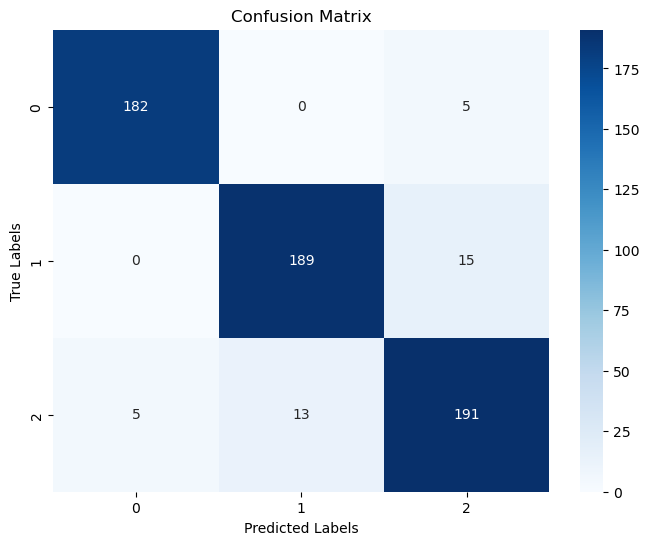

In [11]:
neural_network_sfs_predictor = build_predictors.NeuralNetSFS(config_values, mSFS, labels, user=True)
neural_network_sfs_model, neural_network_sfs_cm, neural_network_sfs_cm_plot = neural_network_sfs_predictor.build_neuralnet_sfs()
neural_network_sfs_cm_plot.show()

### Step 7c: Train the CNN on jSFS

Epoch 1/10
240/240 [==============================] - 2s 7ms/step - loss: 0.4582 - accuracy: 0.8558 - val_loss: 0.1991 - val_accuracy: 0.9367
Epoch 2/10
240/240 [==============================] - 2s 7ms/step - loss: 0.1611 - accuracy: 0.9379 - val_loss: 0.4051 - val_accuracy: 0.8833
Epoch 3/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0944 - accuracy: 0.9688 - val_loss: 0.2042 - val_accuracy: 0.9367
Epoch 4/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0640 - accuracy: 0.9729 - val_loss: 0.2793 - val_accuracy: 0.9383
Epoch 5/10
240/240 [==============================] - 2s 7ms/step - loss: 0.0595 - accuracy: 0.9775 - val_loss: 0.2799 - val_accuracy: 0.9017
Epoch 6/10
240/240 [==============================] - 2s 8ms/step - loss: 0.0329 - accuracy: 0.9871 - val_loss: 0.3070 - val_accuracy: 0.9267
Epoch 7/10
240/240 [==============================] - 2s 8ms/step - loss: 0.0270 - accuracy: 0.9879 - val_loss: 0.3979 - val_accuracy: 0.9183
Epoch 

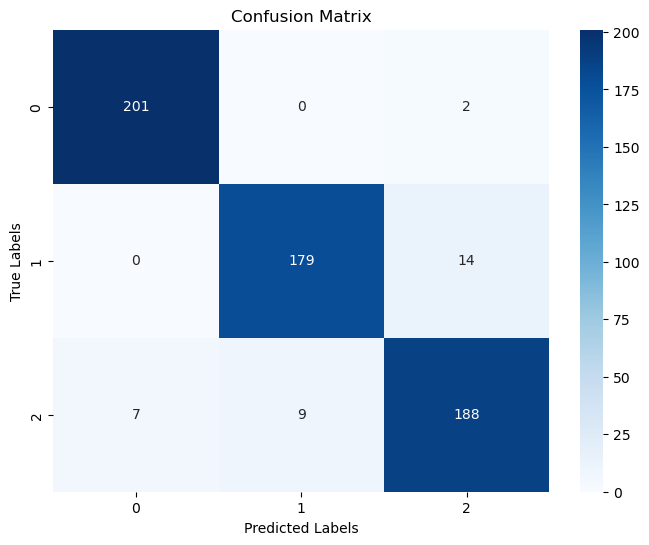

In [12]:
cnn_2d_sfs_predictor = build_predictors.CnnSFS(config_values, jSFS, labels, user=True)
cnn_2d_sfs_model, cnn_2d_sfs_cm, cnn_2d_sfs_cm_plot = cnn_2d_sfs_predictor.build_cnn_sfs()
cnn_2d_sfs_cm_plot.show()

### Step 7d: Train the CNN on alignments

Epoch 1/10
240/240 [==============================] - 9s 34ms/step - loss: 1.0135 - accuracy: 0.4417 - val_loss: 0.4881 - val_accuracy: 0.8617
Epoch 2/10
240/240 [==============================] - 7s 30ms/step - loss: 0.2956 - accuracy: 0.8979 - val_loss: 0.3057 - val_accuracy: 0.8850
Epoch 3/10
240/240 [==============================] - 8s 32ms/step - loss: 0.0639 - accuracy: 0.9833 - val_loss: 0.4027 - val_accuracy: 0.8867
Epoch 4/10
240/240 [==============================] - 9s 36ms/step - loss: 0.0145 - accuracy: 0.9975 - val_loss: 0.5075 - val_accuracy: 0.8767
Epoch 5/10
240/240 [==============================] - 8s 34ms/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.5310 - val_accuracy: 0.8783
Epoch 6/10
240/240 [==============================] - 8s 35ms/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.5867 - val_accuracy: 0.8733
Epoch 7/10
240/240 [==============================] - 9s 35ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.6948 - val_accuracy: 0.8517

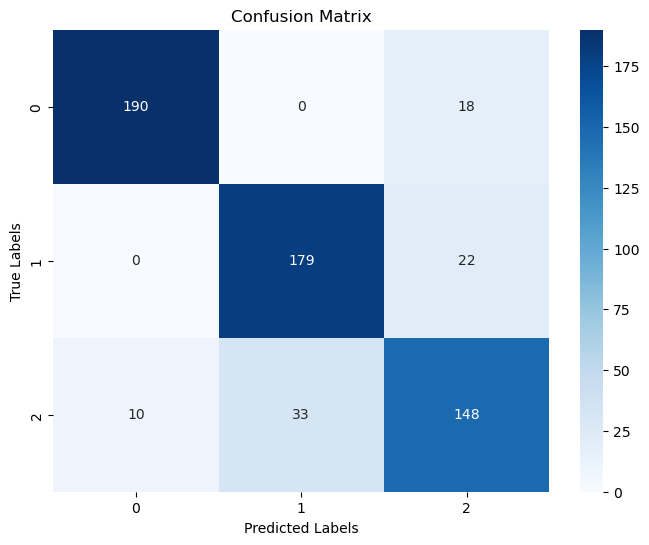

In [13]:
cnn_npy_predictor = build_predictors.CnnNpy(config_values, arrays, labels, user=True)
cnn_npy_model, cnn_npy_cm, cnn_npy_cm_plot = cnn_npy_predictor.build_cnn_npy()
cnn_npy_cm_plot.show('cnn_npy_confusion.png')

## Step 8: Now, we are ready to apply our classifiers to our empirical data.

We will use the four classifiers trained above to make predictions on our empirical data.

### Step 8a: Random Forest predictions

In [14]:
results_rf = random_forest_sfs_predictor.predict(random_forest_sfs_model, empirical_msfs)
print(results_rf)

╒═════════════╤═══════════╤═══════════╤═══════════╕
│             │   Model 0 │   Model 1 │   Model 2 │
╞═════════════╪═══════════╪═══════════╪═══════════╡
│ Replicate 1 │     0.138 │     0.066 │     0.796 │
╘═════════════╧═══════════╧═══════════╧═══════════╛


### Step 8b: FCNN predictions

In [15]:
results_fcnn = neural_network_sfs_predictor.predict(neural_network_sfs_model, empirical_msfs)
print(results_fcnn)

1/1 [==============================] - 0s 46ms/step
╒═════════════╤═════════════╤═════════════╤═══════════╕
│             │     Model 0 │     Model 1 │   Model 2 │
╞═════════════╪═════════════╪═════════════╪═══════════╡
│ Replicate 1 │ 7.86183e-08 │ 9.32586e-05 │  0.999907 │
╘═════════════╧═════════════╧═════════════╧═══════════╛


### Step 8c: CNN SFS predictions

In [16]:
results_cnn = cnn_2d_sfs_predictor.predict(cnn_2d_sfs_model, empirical_2d_sfs)
print(results_cnn)

1/1 [==============================] - 0s 55ms/step
╒═════════════╤═════════════╤════════════╤═══════════╕
│             │     Model 0 │    Model 1 │   Model 2 │
╞═════════════╪═════════════╪════════════╪═══════════╡
│ Replicate 1 │ 2.49646e-07 │ 7.3977e-06 │  0.999992 │
╘═════════════╧═════════════╧════════════╧═══════════╛


### Step 8d: CNN alignments predictions

In [17]:
results_npy_cnn = cnn_npy_predictor.predict(cnn_npy_model, empirical_array)
print(results_npy_cnn)

1/1 [==============================] - 0s 57ms/step
╒═════════════╤═════════════╤═══════════╤═══════════╕
│             │     Model 0 │   Model 1 │   Model 2 │
╞═════════════╪═════════════╪═══════════╪═══════════╡
│ Replicate 1 │ 6.89111e-05 │  0.048675 │  0.951256 │
╘═════════════╧═════════════╧═══════════╧═══════════╛
